In [1]:
%reload_ext autoreload
%autoreload 2

from func import *
import pandas as pd
import pickle
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler




In [2]:
filename = 'all_data_anonymized.csv'
date_col = 'todate'
start_date = '1980-01-01'
seperator = ';'
fill = 0
lim = 5
df_read = load_and_preprocess_data(filename, date_col, start_date, seperator, fill, lim)


d:\master3\Master-thesis\Files\func.py:23: DtypeWarning: Columns (15,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df_read = pd.read_csv(filename, sep=seperator)


In [3]:
windows = [5, 10, 20, 40, 60, 100, 180, 240, 360, 480]
window_m = [10, 30, 60, 100, 180]
assets = df_read.columns
df_feat = add_features(df_read, window_m)

In [4]:
target_days = 10

return_column_shift = 'avgreturn'
volatility_column_shift = 'volatility'
df = add_y_col(df_feat, df_read, date_col, target_days, return_column_shift, volatility_column_shift)

In [5]:
X_train, X_eval, X_test, y_train, y_eval, y_test, X_train_eval, y_train_eval = prepare_training_dataset(df, date_col, shuffle=False, train_split=0.25, eval_split=0.25)

In [6]:
# load all models
%reload_ext autoreload
%autoreload 2
"""NN_model = load_model('NN_model.h5')
ridge_best = pickle.load(open('ridge_model.pickle', 'rb'))
lgb_best = pickle.load(open('lgb_model.pickle', 'rb'))
xgb_best = pickle.load(open('xgb_model.pickle', 'rb'))"""
NN_model, history, X_test_scaled = train_and_evaluate_NN(X_train_eval, y_train_eval, X_eval, y_eval, X_test, y_test)

param_grid_alpha = {'alpha': 10.0}
ridge_best, grid_search = optimize_and_train_ridge(X_train, y_train, X_train_eval, y_train_eval, param_grid_alpha)

param_grid_xgb =  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}

xgb_best, best_params = optimize_and_train_xgb(X_train, y_train, X_eval, y_eval, param_grid_xgb)

param_grid_lgb =  {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 31}

lgb_best, best_params = optimize_and_train_lgb(X_train, y_train, X_eval, y_eval, param_grid_lgb)



C:\Users\Oscar Azrak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 10s 765us/step - accuracy: 0.5139 - loss: 0.2503 - val_accuracy: 0.5325 - val_loss: 0.2484
Epoch 2/5
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 4s 681us/step - accuracy: 0.5276 - loss: 0.2488 - val_accuracy: 0.5412 - val_loss: 0.2476
Epoch 3/5
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 4s 706us/step - accuracy: 0.5372 - loss: 0.2479 - val_accuracy: 0.5445 - val_loss: 0.2472
Epoch 4/5
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 4s 672us/step - accuracy: 0.5459 - loss: 0.2470 - val_accuracy: 0.5517 - val_loss: 0.2457
Epoch 5/5
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 4s 681us/step - accuracy: 0.5501 - loss: 0.2461 - val_accuracy: 0.5565 - val_loss: 0.2451
Restoring model weights from the end of the best epoch: 4.
Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Best hyperparameters: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 31}
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > n

In [7]:
# Store predictions in a dictionary
predictions = {
    "Ridge Classifier": ridge_best.predict(X_test),
    "XGBoost Classifier": xgb_best.predict(X_test),
    "LightGBM Classifier": lgb_best.predict(X_test),
    "Neural Network": NN_model.predict(X_test_scaled)
}   

# Iterate through the dictionary and evaluate each model
for model_name, y_pred in predictions.items():
    print(model_name + ":")
    if model_name == "Neural Network":
        y_pred = (y_pred > 0.5).astype(int)
    evaluate_model_performance(y_test, y_pred)
    print("\n")


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 3s 404us/step
Ridge Classifier:
Accuracy: 0.5155106630994624
Confusion Matrix:
[[78919 20353]
 [73995 21470]]
Precision: 51.335389618152696
Recall: 22.489917770910807
F1 Score: 31.277314841792435
MSE: 48.448933690053764
RMSE: 69.60526825611245


XGBoost Classifier:
Accuracy: 0.5136363402948593
Confusion Matrix:
[[52887 46385]
 [48328 47137]]
Precision: 50.40204443874169
Recall: 49.3762111768711
F1 Score: 49.883854445014734
MSE: 48.63636597051408
RMSE: 69.73977772441928


LightGBM Classifier:
Accuracy: 0.5177906612508152
Confusion Matrix:
[[55333 43939]
 [49965 45500]]
Precision: 50.872661814197386
Recall: 47.66144660346724
F1 Score: 49.2147276424523
MSE: 48.22093387491848
RMSE: 69.44129454072589


Neural Network:
Accuracy: 0.5133590432223973
Confusion Matrix:
[[57460 41812]
 [52955 42510]]
Precision: 50.413889613623965
Recall: 

In [8]:
# keep same index from X_test in df as new df

df_2 = df.loc[X_test.index]
# Use the dates in df_2 to filter rows in df_read
df_2_read = df_read.loc[df_2[date_col].unique()]

# fill missing values with 0
df_2_read.fillna(0, inplace=True)


In [9]:
results_best = {}
results_worst = {}
models = {
    'lgb': lgb_best,
    'xgb': xgb_best,
    'ridge': ridge_best,
    'NN': NN_model
}

df_2_neutral = df_2_read.copy()

for col in df_2_neutral.columns:
    df_2_neutral[col] = 0  


model_dfs = {
    'lgb': df_2_neutral.copy(),
    'xgb': df_2_neutral.copy(),
    'ridge': df_2_neutral.copy(),
    'NN': df_2_neutral.copy()
}


In [10]:


"""def update_df_with_asset_performance(df, portfolios, portfolio_type, hold_days):

    for date_str, assets in portfolios.items():
        start_date = pd.to_datetime(date_str) + pd.DateOffset(days=2)  # Start two days after the given date
        end_date = start_date + pd.DateOffset(days=hold_days - 1)  # Hold for hold_days
        
        # Normalization factor to ensure absolute sum of values is 1
        num_assets = len(assets)
        if num_assets > 0:
            value = 1 / num_assets if portfolio_type == 'best' else -1 / num_assets

        for asset in assets:
            if asset in df.columns:
                df.loc[start_date:end_date, asset] = value

# Gather all best and worst assets for each date for each model
portfolios_best = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}
portfolios_worst = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}



for name, model in models.items():
    best_assets, worst_assets = predict_and_analyze_ext(model, X_test, df, name) 

    # Accumulate best and worst assets for each date
    for date in best_assets['todate'].unique():
        portfolios_best[name].setdefault(date, []).extend(best_assets[best_assets['todate'] == date]['asset'].tolist())
        portfolios_worst[name].setdefault(date, []).extend(worst_assets[worst_assets['todate'] == date]['asset'].tolist())

    update_df_with_asset_performance(model_dfs[name], portfolios_best[name], 'best', target_days)
    update_df_with_asset_performance(model_dfs[name], portfolios_worst[name], 'worst', target_days)"""


"def update_df_with_asset_performance(df, portfolios, portfolio_type, hold_days):\n\n    for date_str, assets in portfolios.items():\n        start_date = pd.to_datetime(date_str) + pd.DateOffset(days=2)  # Start two days after the given date\n        end_date = start_date + pd.DateOffset(days=hold_days - 1)  # Hold for hold_days\n        \n        # Normalization factor to ensure absolute sum of values is 1\n        num_assets = len(assets)\n        if num_assets > 0:\n            value = 1 / num_assets if portfolio_type == 'best' else -1 / num_assets\n\n        for asset in assets:\n            if asset in df.columns:\n                df.loc[start_date:end_date, asset] = value\n\n# Gather all best and worst assets for each date for each model\nportfolios_best = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}\nportfolios_worst = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}\n\n\n\nfor name, model in models.items():\n    best_assets, worst_assets = predict_and_analyze_ext(model, X_test

In [11]:
"""import pandas as pd
import numpy as np

def update_df_with_asset_performance(signals_df, portfolio_df, target_days, returns_df, target_volatility=0.10):
    # Calculate volatilities using the existing function for annualized volatility
    volatilities = calculate_annualized_volatility(returns_df.fillna(0))
    
    # Ensure portfolio DataFrame columns are of float type to avoid dtype issues when updating
    portfolio_df = portfolio_df.astype(float)
    
    # Iterate over each date in the signals DataFrame
    for date_str, row in signals_df.iterrows():
        start_date = pd.to_datetime(date_str) + pd.DateOffset(days=2)  # Start two days after the given date
        end_date = start_date + pd.DateOffset(days=target_days - 1)  # Hold for target_days
        # Filter for assets with non-zero values (either 1 or -1)
        assets = row[row != 0].index.tolist()
        asset_signals = row[row != 0].values  # Get the signals (1 or -1)
        if not assets:
            continue  # Skip if no assets are to be traded on this date

        if start_date in volatilities.index:
            # Asset vol on start date for buying or shorting assets
            asset_vols = volatilities.loc[start_date, assets]
            weights = 1 / asset_vols
            normalized_weights = weights / weights.sum()  # Normalize weights
            
            adjusted_weights = normalized_weights * asset_signals  # Apply signals (-1 for short, 1 for long)
            # Get past returns for the assets
            past_returns = returns_df.loc[start_date - pd.DateOffset(days=target_days):start_date, assets]

            # Calculate portfolio volatility and determine leverage factors    
            port_vol = calculate_portfolio_volatility(adjusted_weights, past_returns)
            leverage = determine_leverage_factors(port_vol, target_volatility)
            adjusted_weights *= leverage  # Apply leverage factor

            # Update the portfolio DataFrame for the holding period
            portfolio_df.loc[start_date:end_date, assets] = adjusted_weights.values
    
    return portfolio_df
            
# Example usage:
# Assume df is your DataFrame where columns are assets and rows are dates with signals
# target_days = 10
# returns_df = DataFrame with returns data for volatility calculation



signals_dfs = {
    'lgb': df_2_neutral.copy(),
    'xgb': df_2_neutral.copy(),
    'ridge': df_2_neutral.copy(),
    'NN': df_2_neutral.copy()
}

portfolio_dfs = {
    'lgb': df_2_neutral.copy(),
    'xgb': df_2_neutral.copy(),
    'ridge': df_2_neutral.copy(),
    'NN': df_2_neutral.copy()
}

for name, model in models.items():
    best_assets, worst_assets = predict_and_analyze_ext(model, X_test, df, name) 
    assets_df = pd.concat([best_assets, worst_assets])
    assets_df['update_value'] = 0
    assets_df.loc[assets_df[name] > assets_df['top_threshold'], 'update_value'] = 1
    assets_df.loc[assets_df[name] < assets_df['bottom_threshold'], 'update_value'] = -1

    pivot_df = assets_df.pivot_table(index='todate', columns='asset', values='update_value', fill_value=0)
    # Update model DataFrame
    signals_dfs[name].update(pivot_df)

    portfolio_dfs[name] = update_df_with_asset_performance(signals_dfs[name], portfolio_dfs[name], target_days, df_read)"""


"import pandas as pd\nimport numpy as np\n\ndef update_df_with_asset_performance(signals_df, portfolio_df, target_days, returns_df, target_volatility=0.10):\n    # Calculate volatilities using the existing function for annualized volatility\n    volatilities = calculate_annualized_volatility(returns_df.fillna(0))\n    \n    # Ensure portfolio DataFrame columns are of float type to avoid dtype issues when updating\n    portfolio_df = portfolio_df.astype(float)\n    \n    # Iterate over each date in the signals DataFrame\n    for date_str, row in signals_df.iterrows():\n        start_date = pd.to_datetime(date_str) + pd.DateOffset(days=2)  # Start two days after the given date\n        end_date = start_date + pd.DateOffset(days=target_days - 1)  # Hold for target_days\n        # Filter for assets with non-zero values (either 1 or -1)\n        assets = row[row != 0].index.tolist()\n        asset_signals = row[row != 0].values  # Get the signals (1 or -1)\n        if not assets:\n         

In [13]:
import pandas as pd
import numpy as np
import pandas as pd


import pandas as pd








signals_dfs = {
    'lgb': df_2_neutral.copy(),
    'xgb': df_2_neutral.copy(),
    'ridge': df_2_neutral.copy(),
    'NN': df_2_neutral.copy()
}

portfolio_dfs = {
    'lgb': df_2_neutral.copy(),
    'xgb': df_2_neutral.copy(),
    'ridge': df_2_neutral.copy(),
    'NN': df_2_neutral.copy()
}

for name, model in models.items():
    best_assets, worst_assets = predict_and_analyze_ext(model, X_test, df, name) 
    assets_df = pd.concat([best_assets, worst_assets])
    assets_df['update_value'] = 0
    assets_df.loc[assets_df[name] > assets_df['top_threshold'], 'update_value'] = 1
    assets_df.loc[assets_df[name] < assets_df['bottom_threshold'], 'update_value'] = -1

    pivot_df = assets_df.pivot_table(index='todate', columns='asset', values='update_value', fill_value=0)
    signals_dfs[name].update(pivot_df)

    portfolio_dfs[name] = update_df_with_asset_performance(signals_dfs[name], portfolio_dfs[name], target_days, df_read)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


KeyboardInterrupt: 

In [ ]:
xgb_weights = portfolio_dfs['xgb']
lgb_weights = portfolio_dfs['lgb']
ridge_weights = portfolio_dfs['ridge']
NN_weights = portfolio_dfs['NN']




xgb_returns = xgb_weights*df_2_read
lgb_returns = lgb_weights*df_2_read
ridge_returns = ridge_weights*df_2_read
NN_returns = NN_weights*df_2_read


xgb_trade_volume = calculate_trade_volume(xgb_weights)
lgb_trade_volume = calculate_trade_volume(lgb_weights)
ridge_trade_volume = calculate_trade_volume(ridge_weights)
NN_trade_volume = calculate_trade_volume(NN_weights)

In [ ]:
#xgb_trade_volume.sum()

xgb_weights.tail(105)

,EQ_0,EQ_1,EQ_2,EQ_3,EQ_4,EQ_5,EQ_6,EQ_7,EQ_8,EQ_9,EQ_10,EQ_11,EQ_12,EQ_13,EQ_14,EQ_15,EQ_16,EQS_0,EQS_1,EQS_2,EQS_3,EQS_4,EQS_5,EQS_6,EQS_7,EQS_8,EQS_9,EQS_10,FI_0,FI_1,FI_2,FI_3,FI_4,FI_5,FI_6,FI_7,FI_8,FI_9,FI_10,FI_11,FI_12,FI_13,FI_14,FXD_0,FXD_1,FXD_2,FXD_3,FXD_4,FXD_5,FXD_6,FXD_7,FXD_8,FXD_9,FXE_0,FXE_1,FXE_2,FXE_3,FXE_4,MACRO_8,MACRO_0,MACRO_1,MACRO_2,MACRO_3,MACRO_4,MACRO_5,MACRO_6,MACRO_7
todate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-08-28,0.0,0.000000,0.0,0.000000,0.000000,0.000000,-4.278916,0.000000,0.000000,0.000000,3.307152,0.000000,0.0,0.000000,-2.938206,-4.732120,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.081470,-23.927592,-9.702527,-3.706778,0.000000,-17.988815,5.357901,-9.492186,5.571090,-20.062431,7.216494,0.000000,5.878949,0.000000,6.264355,0.000000,4.869992,-7.654857,6.617907,-6.387147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.883181,3.832126,1.941692,-13.038536,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-08-29,0.0,0.000000,0.0,0.000000,0.000000,0.000000,-4.278916,0.000000,0.000000,0.000000,3.307152,0.000000,0.0,0.000000,-2.938206,-4.732120,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.081470,-23.927592,-9.702527,-3.706778,0.000000,-17.988815,5.357901,-9.492186,5.571090,-20.062431,7.216494,0.000000,5.878949,0.000000,6.264355,0.000000,4.869992,-7.654857,6.617907,-6.387147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.883181,3.832126,1.941692,-13.038536,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-08-30,0.0,0.000000,0.0,0.000000,0.000000,0.000000,-4.278916,0.000000,0.000000,0.000000,3.307152,0.000000,0.0,0.000000,-2.938206,-4.732120,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.081470,-23.927592,-9.702527,-3.706778,0.000000,-17.988815,5.357901,-9.492186,5.571090,-20.062431,7.216494,0.000000,5.878949,0.000000,6.264355,0.000000,4.869992,-7.654857,6.617907,-6.387147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.883181,3.832126,1.941692,-13.038536,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-08-31,0.0,0.000000,0.0,0.000000,0.000000,0.000000,-4.278916,0.000000,0.000000,0.000000,3.307152,0.000000,0.0,0.000000,-2.938206,-4.732120,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.081470,-23.927592,-9.702527,-3.706778,0.000000,-17.988815,5.357901,-9.492186,5.571090,-20.062431,7.216494,0.000000,5.878949,0.000000,6.264355,0.000000,4.869992,-7.654857,6.617907,-6.387147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.883181,3.832126,1.941692,-13.038536,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-09-01,0.0,0.000000,0.0,0.000000,0.000000,0.000000,-4.278916,0.000000,0.000000,0.000000,3.307152,0.000000,0.0,0.000000,-2.938206,-4.732120,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.081470,-23.927592,-9.702527,-3.706778,0.000000,-17.988815,5.357901,-9.492186,5.571090,-20.062431,7.216494,0.000000,5.878949,0.000000,6.264355,0.000000,4.869992,-7.654857,6.617907,-6.387147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.883181,3.832126,1.941692,-13.038536,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-09-04,0.0,0.000000,0.0,0.000000,0.000000,0.000000,-4.278916,0.000000,0.000000,0.000000,3.307152,0.000000,0.0,0.000000,-2.938206,-4.732120,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.081470,-23.927592,-9.702527,-3.706778,0.000000,-17.988815,5.357901,-9.492186,5.571090,-20.062431,7.216494,0.000000,5.878949,0.000000,6.264355,0.000000,4.869992,-7.654857,6.617907,-6.387147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.883181,3.832126,1.941692,-13.038536,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-09-05,0.0,0.000000,0.0,0.000000,0.000000,0.000000,-4.278916,0.000000,0.000000,0.000000,3.307152,0.000000,0.0,0.000000,-2.938206,-

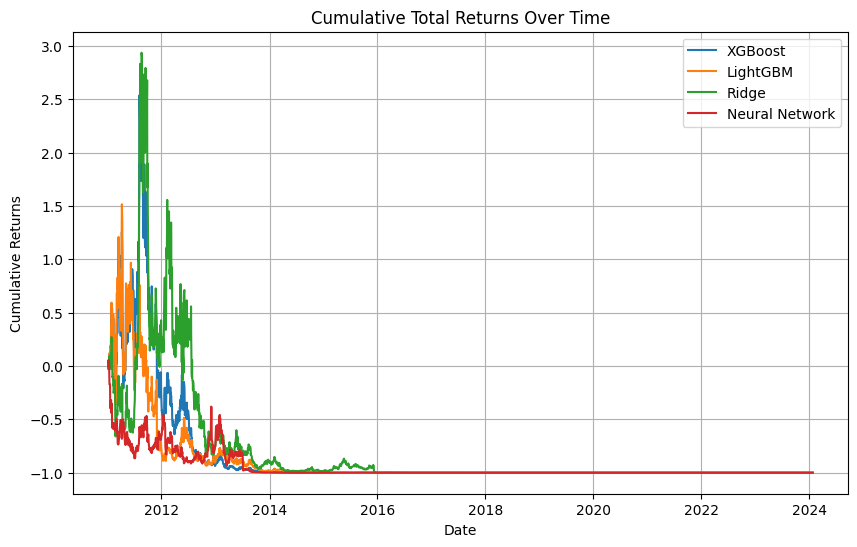

In [ ]:
import matplotlib.pyplot as plt

# Sum the returns across all assets for each day to get the daily total returns for each model
xgb_total_returns = xgb_returns.sum(axis=1)
lgb_total_returns = lgb_returns.sum(axis=1)
ridge_total_returns = ridge_returns.sum(axis=1)
NN_total_returns = NN_returns.sum(axis=1)

# Calculate the cumulative total returns for each model
xgb_cumulative_total_returns = (1 + xgb_total_returns).cumprod() - 1
lgb_cumulative_total_returns = (1 + lgb_total_returns).cumprod() - 1
ridge_cumulative_total_returns = (1 + ridge_total_returns).cumprod() - 1
NN_cumulative_total_returns = (1 + NN_total_returns).cumprod() - 1

# use cumsum 
#xgb_cumulative_total_returns = xgb_total_returns.cumsum()
#lgb_cumulative_total_returns = lgb_total_returns.cumsum()
#ridge_cumulative_total_returns = ridge_total_returns.cumsum()
#NN_cumulative_total_returns = NN_total_returns.cumsum()

# Plot the cumulative total returns for each model
plt.figure(figsize=(10, 6))
plt.plot(xgb_cumulative_total_returns, label='XGBoost')
plt.plot(lgb_cumulative_total_returns, label='LightGBM')
plt.plot(ridge_cumulative_total_returns, label='Ridge')
plt.plot(NN_cumulative_total_returns, label='Neural Network')
plt.title('Cumulative Total Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
xgb_total_returns.tail(125)

todate
2023-07-31    0.002444
2023-08-01   -0.109846
2023-08-02    0.058055
2023-08-03   -0.100996
2023-08-04   -0.010440
2023-08-07   -0.012326
2023-08-08    0.074500
2023-08-09    0.062818
2023-08-10   -0.014051
2023-08-11   -0.117895
2023-08-14    0.097158
2023-08-15    0.101707
2023-08-16    0.103278
2023-08-17    0.025967
2023-08-18    0.111047
2023-08-21    0.002221
2023-08-22   -0.013342
2023-08-23    0.077952
2023-08-24   -0.235542
2023-08-25    0.081367
2023-08-28    0.002199
2023-08-29   -0.039820
2023-08-30   -0.079772
2023-08-31    0.026941
2023-09-01   -0.110470
2023-09-04   -0.159847
2023-09-05    0.017193
2023-09-06    0.064525
2023-09-07    0.122291
2023-09-08   -0.036818
2023-09-11   -0.093432
2023-09-12   -0.031088
2023-09-13    0.011614
2023-09-14    0.388655
2023-09-15   -0.183503
2023-09-18   -0.110909
2023-09-19   -0.094246
2023-09-20   -0.113812
2023-09-21   -0.248807
2023-09-22   -0.074902
2023-09-25   -0.261851
2023-09-26    0.142868
2023-09-27   -0.069832
2023

In [ ]:
#print trade volume
print("XGBoost trade volume:")
print(xgb_trade_volume.sum())
print("\n")
print("LightGBM trade volume:")
print(lgb_trade_volume.sum())
print("\n")
print("Ridge trade volume:")
print(ridge_trade_volume.sum())
print("\n")
print("Neural Network trade volume:")
print(NN_trade_volume.sum())
print("\n")

XGBoost trade volume:
53263


LightGBM trade volume:
52336


Ridge trade volume:
53941


Neural Network trade volume:
53322




In [ ]:
ridge_metrics = financial_metrics(ridge_total_returns)
lgb_metrics = financial_metrics(lgb_total_returns)
xgb_metrics = financial_metrics(xgb_total_returns)
NN_metrics = financial_metrics(NN_total_returns)

In [ ]:
print("Ridge metrics:")
print(ridge_metrics)
print("\n")
print("LightGBM metrics:")
print(lgb_metrics)
print("\n")
print("XGBoost metrics:")
print(xgb_metrics)
print("\n")
print("Neural Network metrics:")
print(NN_metrics)


Ridge metrics:
{'Average Yearly Return': 1.1122562837951206, 'Average Yearly Standard Deviation': 2.9265510385559046, 'Sharpe Ratio': 0.38005702587847545, 'Max Drawdown': -58.397298546930315, 'Volatility': 2.9265510385559046, 'Calmar Ratio': 0.019046365353720406, 'Skewness': -0.11332882625254175, 'Kurtosis': 2.302097017422547}


LightGBM metrics:
{'Average Yearly Return': 0.873044379127727, 'Average Yearly Standard Deviation': 2.868699479031352, 'Sharpe Ratio': 0.3043345549121514, 'Max Drawdown': -2.1706563787966333, 'Volatility': 2.868699479031352, 'Calmar Ratio': 0.402202940850419, 'Skewness': -0.488753240797341, 'Kurtosis': 4.739458830734838}


XGBoost metrics:
{'Average Yearly Return': 0.7416623086097006, 'Average Yearly Standard Deviation': 2.763811559849774, 'Sharpe Ratio': 0.26834763968134406, 'Max Drawdown': -1.3477450369873119, 'Volatility': 2.763811559849774, 'Calmar Ratio': 0.5502986753841653, 'Skewness': -0.4712322687148651, 'Kurtosis': 4.769781030131262}


Neural Network m

In [ ]:
%reload_ext autoreload
%autoreload 2



In [ ]:


def update_portfolio_with_volatility_control(df, portfolios, returns_df, hold_days, portfolio_type, target_volatility=0.10):
    volatilities = calculate_annualized_volatility(returns_df)
    for date_str, assets in portfolios.items():
        start_date = pd.to_datetime(date_str).normalize() + pd.DateOffset(days=2)
        end_date = start_date + pd.DateOffset(days=hold_days - 1)

        # Assuming returns_df already filtered for relevant assets
        past_returns = returns_df.loc[start_date-pd.DateOffset(days=365):start_date, assets]
        if start_date in df.index:
            asset_vols = volatilities.loc[start_date, assets].dropna()
            # Calculate weights based on inverse volatility
            if not asset_vols.empty:
                weights = 1 / asset_vols
                normalized_weights = weights / weights.sum()

                # Calculate portfolio volatility and adjust for target
                portfolio_volatility = calculate_portfolio_volatility(normalized_weights, past_returns)
                leverage_factor = determine_leverage_factor(portfolio_volatility, target_volatility)
                adjusted_weights = apply_leverage(normalized_weights, leverage_factor)

                # Apply weights based on portfolio_type
                 
                if portfolio_type == 'best': 
                    sign = 1
                else: 
                    -1
                for asset, weight in adjusted_weights.items():
                    df.loc[start_date:end_date, asset] = weight * sign


model_dfs_new = {
    'lgb': df_2_neutral.copy(),
    'xgb': df_2_neutral.copy(),
    'ridge': df_2_neutral.copy(),
    'NN': df_2_neutral.copy()
}


portfolios_best_new = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}
portfolios_worst_new = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}



for name, model in models.items():
    best_assets, worst_assets = predict_and_analyze_ext(model, X_test, df, name) 

    # Accumulate best and worst assets for each date
    for date in best_assets['todate'].unique():
        portfolios_best_new[name].setdefault(date, []).extend(best_assets[best_assets['todate'] == date]['asset'].tolist())
        portfolios_worst_new[name].setdefault(date, []).extend(worst_assets[worst_assets['todate'] == date]['asset'].tolist())

    update_portfolio_with_volatility_control(model_dfs_new[name], portfolios_best_new[name], df_read, target_days,portfolio_type='best' , target_volatility=0.10)
    update_portfolio_with_volatility_control(model_dfs_new[name], portfolios_worst_new[name], df_read, target_days, portfolio_type='worst', target_volatility=0.10)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


ValueError: Weights and covariance matrix dimension mismatch.